In [2]:
%load_ext autoreload
%autoreload 2

import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import datetime
from pathlib import Path
import matplotlib.colors as mcolors

In [3]:
broad_cell_types_color_mapping = {
    "Lymphatic Endothelial Cells": "#ffb695",
    "Macrophages": "#ff40ff",
    "Vascular Endothelial Cells": "#a4e000",
    "Pericytes": "#9f7704",
    "Fibroblasts": "#c7d0c0",
    "T-cells": "#941100",
    "Keratinocytes": "#181c82",
    "Dendritic cells": "#ff9300",
    "Spinous to Granular Cells": "#034cff",
    "Pilosebaceous Cells": "#bbbde2",
    "B-cells": "#f12d00",
    "Melanocytes": "#00bbbf",
}


niches_order = [
    "Tumor Core",
    "Tumor",
    "Tumor Boundary",
    "VEC Stroma",
    "Macrophage Immune Stroma",
    "T-cell Immune Stroma",
    "Stroma",
    "Immune",
    "Basal-Dermis",
    "Differentiated Epidermis",
]

niche_with_tumor_proximity_order = [
    "Tumor Core",
    "Tumor",
    "Tumor Boundary",
    "TA VEC Stroma",
    "Macrophage Immune Stroma",
    "T-cell Immune Stroma",
    "Stroma",
    "Immune",
    "nTA VEC Stroma",
    "Basal-Dermis",
    "Differentiated Epidermis",
]

niche_colors = {
    # SKIN
    "Basal-Dermis": "#b299e3",
    "Differentiated Epidermis": "#ffd000",
    # STROMA
    "Stroma": "#646500",
    "VEC Stroma": "#00e50c",
    "TA VEC Stroma": "#00e50c",
    "nTA VEC Stroma": "#0f640d",
    # IMMUNE
    "Macrophage Immune Stroma": "#00dbf4",
    "T-cell Immune Stroma": "#0051f9",
    "Immune": "#c100f9",
    # TUMOR
    "Tumor Core": "#450000",
    "Tumor": "#eb0000",
    "Tumor Boundary": "#faa0aa",
}

stage_colors = {
    "nodular": "#FF8783",
    "plaque": "#FFFFE6",
    "patch": "#A6EC9A",
    "control": "#808080",
}


# Example function to calculate median without outliers
def median_without_outliers(series):
    # Calculate Q1 and Q3
    series = series.dropna()
    series = series[np.isfinite(series)]
    try:
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
    except Exception as e:
        print(f"Error computing quantiles: {e}")

    # Calculate IQR
    IQR = Q3 - Q1
    # Determine outlier bounds
    # Determine outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers
    filtered_series = series[(series >= lower_bound) & (series <= upper_bound)]
    # Return the median of the filtered data
    return filtered_series.median()


def save_plot(fig, filename, vector="svg"):
    plt.savefig(png_output_dir / f"{filename}.png", dpi=300, bbox_inches="tight")
    if vector == "svg":
        plt.savefig(
            svg_output_dir / f"{filename}.svg",
            dpi=300,
            transparent=False,
            format="svg",
            bbox_inches="tight",
        )
    plt.close(fig)


def get_cores_by_stage(adata, stage="nodular"):
    cores = []
    for path_block in adata.obs["path_block_core"].unique():
        adata_subset = adata[adata.obs["path_block_core"] == path_block]
        stage_pathblock = adata_subset.obs["Stage"].unique()[0]
        if stage == stage_pathblock:
            cores.append(path_block)
    return cores
# adata_obs

# Table of Contents
1. [Distance of niche from tumor](#distance-of-niche-from-tumor)
2. [Vessel size for each niche](#vessel-size-for-each-niche)
3. [Vessel density for each niche](#vessel-density-for-each-niche)
4. [Vessel density for each stage](#vessel-density-for-each-stage)


## Read Data

In [ ]:
adata_path = '../data/spatial_single_cell_KS_adata.h5ad'
adata = sc.read_h5ad(adata_path)

## Distance of Niche from Tumor

In [ ]:
median_filtered_per_group = adata.obs.groupby(
    'niche_with_tumor_proximity', observed=False)['distance_to_core'].apply(
        median_without_outliers).reset_index(name='median_without_outliers')
median_filtered_per_group.sort_values(by='median_without_outliers', inplace=True)
order = median_filtered_per_group['niche_with_tumor_proximity'].to_list()

In [ ]:
def plot_order(pdata, stage='all', distance_column='distance_to_core', palette=None):
    median_filtered_per_group = pdata.obs.groupby('niche_with_tumor_proximity', observed=False)[distance_column] \
                                            .apply(median_without_outliers).reset_index(name='median_without_outliers')
    median_filtered_per_group.sort_values(by='median_without_outliers', inplace=True)
    order = median_filtered_per_group['niche_with_tumor_proximity'].to_list()
    fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
    x_col = 'niche_with_tumor_proximity'
    if palette is not None:
        sns.boxplot(x=x_col, hue=x_col, y=distance_column, legend=False, palette=palette,
                    data=pdata.obs, order=order, showfliers=False, ax=ax, linecolor='#333333', linewidth=.5)
    else:
        sns.boxplot(x=x_col, y=distance_column, legend=False, color='white',
                    data=pdata.obs, order=order, showfliers=False, ax=ax, linecolor='#333333', linewidth=.5)

    # Add labels
    plt.xlabel('Niche', fontsize=16)
    plt.ylabel('Distance to Tumor Core ($\mu m$)', fontsize=16)

    # Show the plot
    plt.xticks(rotation=90)  # Rotate x-axis labels if needed
    plt.tight_layout()  # Adjust layout

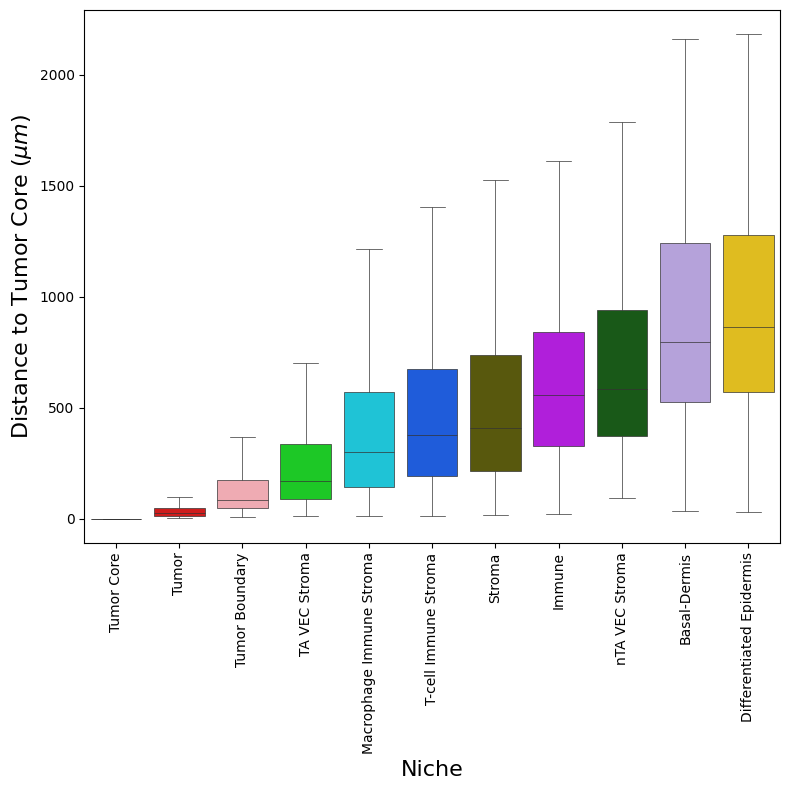

In [ ]:
plot_order(adata, palette=niche_colors)


## Vessel size for each niche

In [27]:
nodular_cores = get_cores_by_stage(adata, 'nodular')

/tmp/ipykernel_2427449/2434338779.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


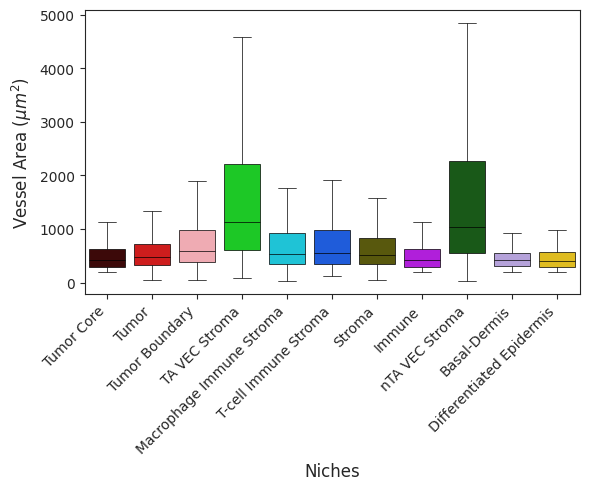

In [32]:
sns.set_style("ticks")

fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=100)
adata_subset = adata[adata.obs['path_block_core'].isin(nodular_cores)]

sns.boxplot(data=adata_subset.obs, x='niche_with_tumor_proximity', y='vessel_area', ax=ax, 
            hue='niche_with_tumor_proximity', palette=niche_colors,
            showfliers=False, color='white',     # The width of the boxe
            boxprops=dict(edgecolor='black',),
            whiskerprops=dict(color='black', linewidth=0.5),
            medianprops=dict(color='black', linewidth=0.5),
            capprops=dict(color='black', linewidth=0.5),
            linewidth = 0.5, order=niche_with_tumor_proximity_order,
            flierprops=dict(marker='.', color='red', markersize=5, alpha=0.5))  # The width of the box lines

ax.set_xlabel('Niches', fontsize=12)
ax.set_ylabel('Vessel Area ($\mu m^2$)', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Display the plots
plt.tight_layout()

## Vessel density for each niche

/tmp/ipykernel_2817638/2706464536.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


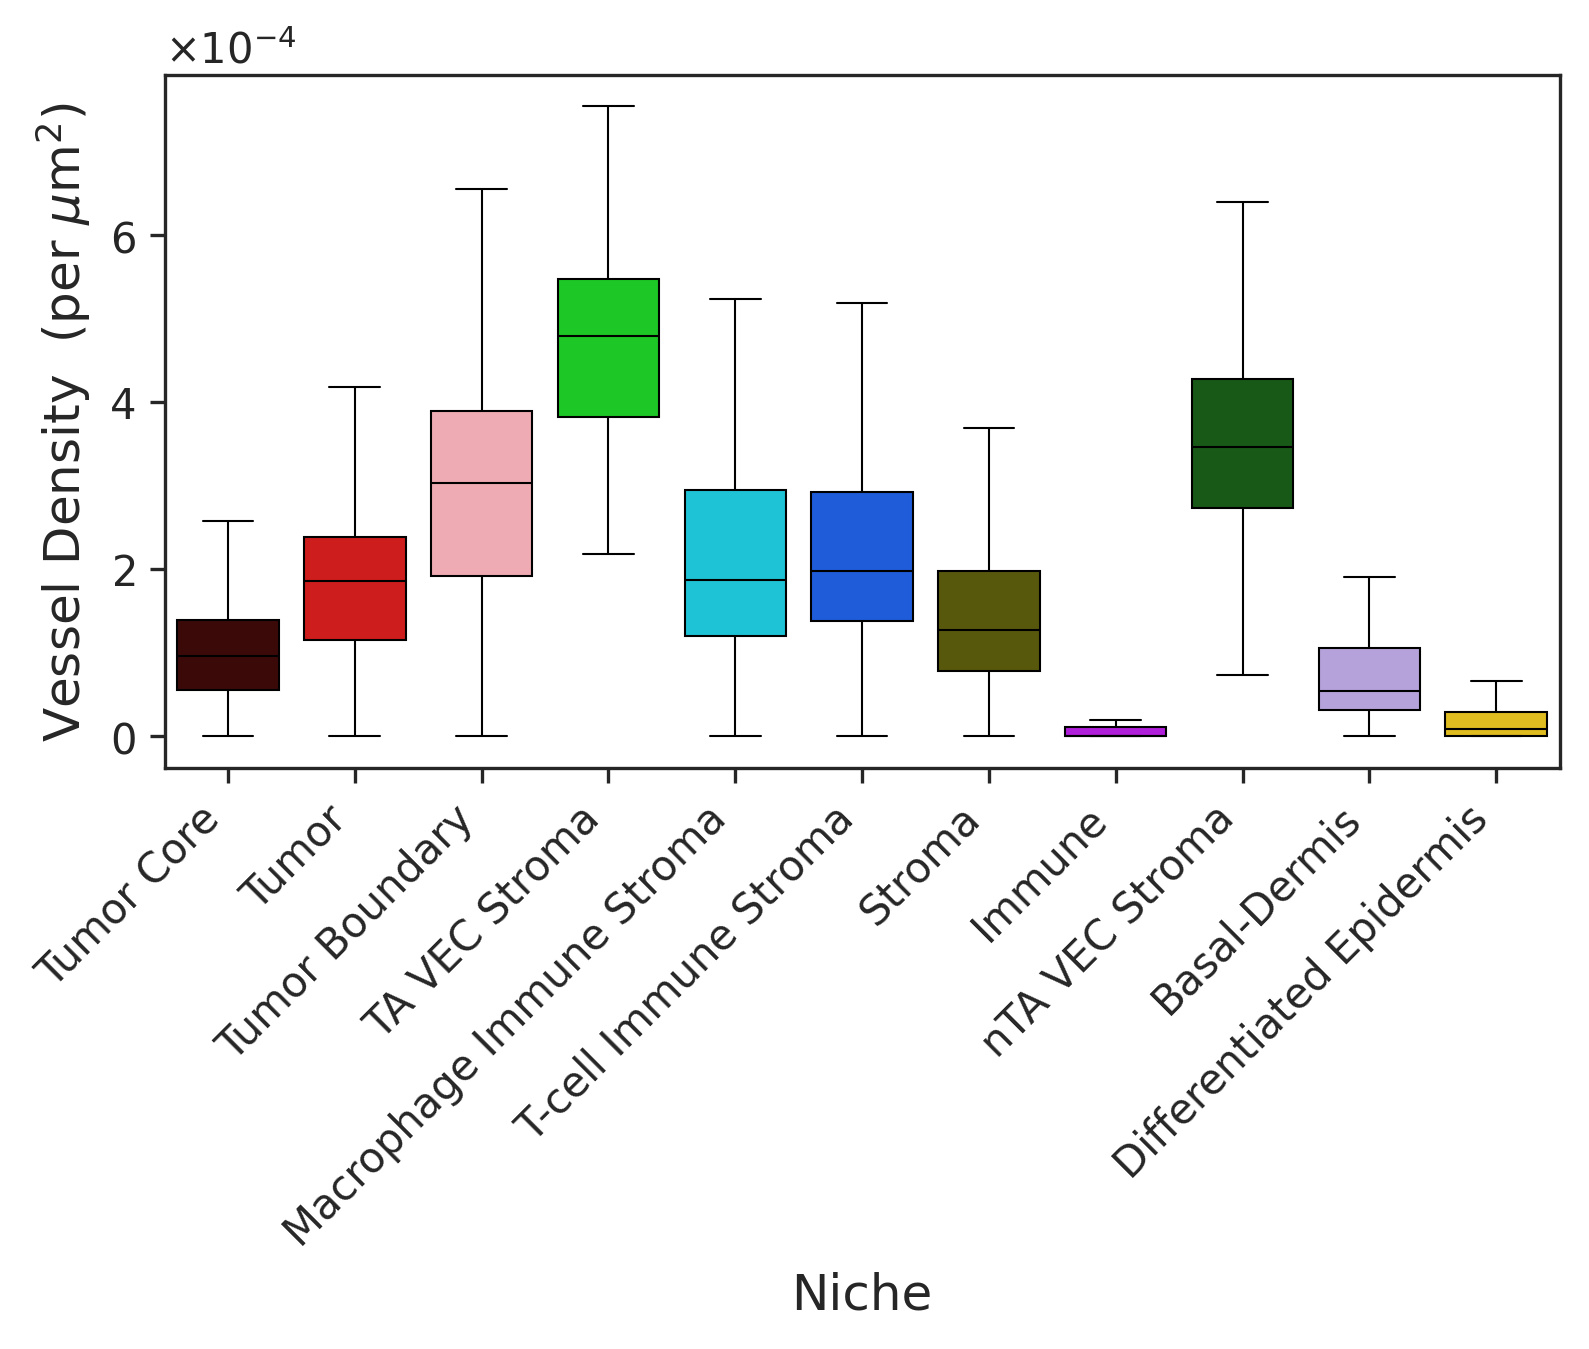

In [ ]:
from matplotlib.ticker import ScalarFormatter

sns.set_style("ticks")

fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=300)
sns.boxplot(x='niche_with_tumor_proximity', y='normalized_count',
            hue='niche_with_tumor_proximity', palette=niche_colors,
             data=adata.uns['vessel_counts_per_core_per_niche'],
            ax=ax, order=niche_with_tumor_proximity_order, linewidth=.5, color='white', showfliers=False,
            boxprops=dict(edgecolor='black',),
            whiskerprops=dict(color='black', linewidth=0.5),
            medianprops=dict(color='black', linewidth=0.5),
            capprops=dict(color='black', linewidth=0.5),
            flierprops=dict(marker='.', color='black', markersize=5, alpha=0.5))
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))  # Force scientific notation

ax.set_ylabel('Vessel Density  (per $\mu$m$^2$)', fontsize=12)
ax.set_xlabel('Niche', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

## Vessel density for each stage

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

patch vs. control: ****
plaque vs. patch: ns
nodular vs. plaque: ****
plaque vs. control: ****
nodular vs. patch: ****
nodular vs. control: ****


/tmp/ipykernel_2427449/4163892123.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_2427449/4163892123.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['Control', 'Patch', 'Plaque', 'Nodular'])


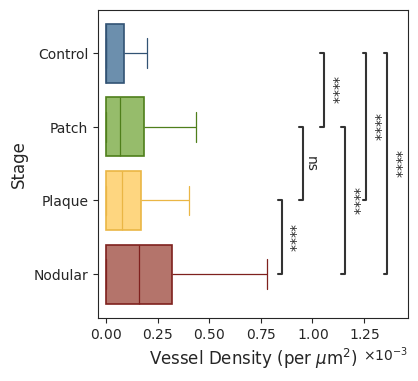

In [ ]:
# How to add alpha (transparency) to per‑box fill and outline
# Works with seaborn 0.11–0.13+, matplotlib 3.x

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu
from statannotations.Annotator import Annotator

data=adata.uns['vessel_counts_per_core_per_niche']
order = ['control', 'patch', 'plaque', 'nodular']

face_palette = {
    'control': '#6c8fad',
    'patch':   '#96bc6b',
    'plaque':  '#fed680',
    'nodular': '#b4746b',
}

edge_palette = {
    'control': '#325374',
    'patch':   '#4f7f1b',
    'plaque':  '#eab645',
    'nodular': '#7f211e',
}

# === choose your transparencies (0=fully transparent, 1=opaque) ===
FACE_ALPHA = 1   # for the box fills only
EDGE_ALPHA = 1.00   # for box edges, whiskers, caps, medians
LINE_WIDTH_BOX = 1.2
LINE_WIDTH_LINES = 0.9

sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=100)

sns.boxplot(
    y='Stage', x='normalized_count', data=data,
    order=order, ax=ax, palette=face_palette,
    linewidth=LINE_WIDTH_BOX, showfliers=False,
)

# ---- Grab boxes robustly across seaborn versions ----
boxes = list(ax.artists)
if len(boxes) == 0:
    boxes = [p for p in ax.patches if isinstance(p, mpl.patches.PathPatch)]

# All whiskers/caps/medians are Line2D in ax.lines
lines = [l for l in ax.lines if isinstance(l, mpl.lines.Line2D)]
lines_per_box = max(1, int(round(len(lines) / max(1, len(boxes)))))

for i, stage in enumerate(order):
    # Box fill + outline with desired alpha
    box = boxes[i]
    box.set_facecolor(mcolors.to_rgba(face_palette[stage], FACE_ALPHA))
    box.set_edgecolor(mcolors.to_rgba(edge_palette[stage], EDGE_ALPHA))
    box.set_linewidth(LINE_WIDTH_BOX)

    # Whiskers, caps, median for this box
    start = i * lines_per_box
    end = start + lines_per_box
    for line in lines[start:end]:
        rgba = mcolors.to_rgba(edge_palette[stage], EDGE_ALPHA)
        line.set_color(rgba)
        line.set_linewidth(LINE_WIDTH_LINES)
        if hasattr(line, 'set_alpha'):
            line.set_alpha(EDGE_ALPHA)

# Axis formatting (optional – match your original)
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
ax.set_xlabel('Vessel Density (per $\\mu$m$^2$)', fontsize=12)
ax.set_ylabel('Stage', fontsize=12)
ax.set_yticklabels(['Control', 'Patch', 'Plaque', 'Nodular'])

# Perform pairwise comparisons and annotate significant differences 
pairs = [('control', 'patch'), ('control', 'plaque'), ('control', 'nodular'), ('patch', 'plaque'), ('patch', 'nodular'), ('plaque', 'nodular')] 
# Create a list to store results for the Annotator 
results = [] 
for pair in pairs: 
    group1 = data[data['Stage'] == pair[0]]['normalized_count'] 
    group2 = data[data['Stage'] == pair[1]]['normalized_count'] 
    stat, p_value = mannwhitneyu(group1, group2) 
    results.append((pair[0], pair[1], p_value)) 
    
# Set significance threshold 
alpha = 0.05


# BH/FDR correction across the 6 pairwise tests
raw_pvals = [r[2] for r in results]
rej, pvals_bh, *_ = multipletests(raw_pvals, alpha=0.05, method='fdr_bh')

# NOTE: Run annotations *after* the coloring above; annotation may add extra ax.lines.
annotator = Annotator(ax, pairs, data=data, x='normalized_count', y='Stage', orient='h')
formatted_pvalues = []
for p in pvals_bh:
    if p > alpha:
        formatted_pvalues.append(f'ns')
    elif p < 1e-5:
        formatted_pvalues.append(f'****')
    elif p < 1e-4:
        formatted_pvalues.append(f'***')
    elif p < 1e-3:
        formatted_pvalues.append(f'**')
    elif p < 1e-2:
        formatted_pvalues.append(f'*')
annotator.set_custom_annotations(formatted_pvalues)
annotator.annotate()
# save_plot(fig=fig, filename=f'{section_num}_vessel_density_per_stage_boxplot_horizontal')
plt.show()


In [47]:
control = data.loc[(data.Stage == "control"), "normalized_count"].values
patch = data.loc[(data.Stage == "patch"), "normalized_count"].values
plaque = data.loc[(data.Stage == "plaque"), "normalized_count"].values
nodular = data.loc[(data.Stage == "nodular"), "normalized_count"].values


In [48]:
stat_results = [
  mannwhitneyu(control, nodular, alternative="two-sided"),
  mannwhitneyu(control, patch, alternative="two-sided"),
  mannwhitneyu(control, plaque, alternative="two-sided"),
  mannwhitneyu(patch, plaque, alternative="two-sided"),
  mannwhitneyu(nodular, plaque, alternative="two-sided"),
  mannwhitneyu(nodular, patch, alternative="two-sided"),
]

pvalues = [result.pvalue for result in stat_results]

print("Control vs Nodular: \n", stat_results[0], "\n")
print("Control vs Patch: \n", stat_results[1], "\n")
print("Control vs Plaque: \n", stat_results[2], "\n")
print("Patch vs Plaque: \n", stat_results[3], "\n")
print("Nodular vs Plaque: \n", stat_results[4], "\n")
print("Nodular vs Patch: \n", stat_results[5], "\n")


Control vs Nodular: 
 MannwhitneyuResult(statistic=np.float64(80032.0), pvalue=np.float64(2.3323169506060203e-23)) 

Control vs Patch: 
 MannwhitneyuResult(statistic=np.float64(10655.5), pvalue=np.float64(6.337584564935857e-08)) 

Control vs Plaque: 
 MannwhitneyuResult(statistic=np.float64(11611.0), pvalue=np.float64(1.0132129961774979e-09)) 

Patch vs Plaque: 
 MannwhitneyuResult(statistic=np.float64(26966.0), pvalue=np.float64(0.5553575600898784)) 

Nodular vs Plaque: 
 MannwhitneyuResult(statistic=np.float64(341748.5), pvalue=np.float64(2.0232373088375837e-09)) 

Nodular vs Patch: 
 MannwhitneyuResult(statistic=np.float64(300948.5), pvalue=np.float64(1.782222352401375e-09)) 

